In [14]:
# Set up
%pylab inline

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats
import seaborn.apionly as sns


causal = pd.read_csv("/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/Merged_Best_causality.Table", sep="\t")
# Examples - Exon eSTR step size=6
#genes=["ENSG00000166311.5","ENSG00000173230.11","ENSG00000126464.9","ENSG00000154134.10","ENSG00000141404.11","ENSG00000108669.12","ENSG00000121101.11","ENSG00000198931.6","ENSG00000162244.6","ENSG00000182149.16","ENSG00000169599.8","ENSG00000165804.11","ENSG00000100065.10","ENSG00000174177.8","ENSG00000248487.4","ENSG00000055483.15"]
#causal=causal.loc[causal['gene'].isin(genes)]
"""
#Example top causal
causal = causal[causal["top.variant"].apply(lambda x: "SNP" not in x)]
causal = causal.sort_values("best.score", ascending=False)
"""
num = 10
GENES = list(causal["gene"])[0:num]
CHROMS = list(causal["chrom"].apply(lambda x: x[3:]))[0:num]
STARTS = list(causal["best.str.start"])[0:num]
TISSUES = list(causal["best.tissue"])[0:num]


# Examples - near TSS
"""
num = 100
FEATUREDIR = "/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/"
data = pd.read_csv(os.path.join(FEATUREDIR, "GTEx_merged_causality_tsstes.tab"), sep="\t")
data = data[data["dist.to.tss"].apply(abs)<=1000]
data = data.sort_values("dist.to.tss")
data = data.head(n=num)
GENES = list(data["gene"])
TISSUES = list(data["best.tissue"])
STARTS = list(data["best.str.start"])
CHROMS = list(data["chrom"])
QVALS = list(data["best.q"])

#ENSG00000101361.10	chr20	2633379.0 NOP56

GENES=["ENSG00000101361.10"]
CHROMS=["20"]
STARTS=[2633379]
QVALS=[None]
TISSUES=["Muscle-Skeletal"]
"""
COLORS = {
    "Artery-Aorta":"salmon",
    "Artery-Tibial": "red",
    "Adipose-Subcutaneous": "darkorange",    
    "Adipose-Visceral":"orange",
    "Brain-Caudate":"lemonchiffon"   , 
    "Brain-Cerebellum":"yellow",
    "Cells-Transformedfibroblasts": "skyblue",
    "Esophagus-Mucosa": "sienna",
    "Esophagus-Muscularis":"burlywood",
    "Heart-LeftVentricle":"darkviolet",
    "Lung": "greenyellow",
    "Muscle-Skeletal": "mediumslateblue",
    "Nerve-Tibial":"gold",
    "Skin-NotSunExposed":"blue",
    "Skin-SunExposed":"cornflowerblue",
    "Thyroid":"green",
    "WholeBlood": "m",
    "permuted": "gray"
}

Populating the interactive namespace from numpy and matplotlib


In [8]:
def ExtractData(gene, chrom, start, tissue):
    if "(" in tissue: tissue = tissue.split("(")[0]
    vcf = "/storage/szfeupe/Runs/650GTEx_estr/Merged_STRs_all_samples.vcf.gz"
    # Pull out STR genotypes
    cmd = """bcftools query -r %s:%s-%s -f"[%%SAMPLE\\t%%GB\\n]" %s | \
    grep -v "\." | sed 's/|/\\t/' | awk '{print $1 "\\t" $2+$3}' > str_genotypes.tab"""%(chrom, start, start, vcf)
    os.system(cmd)
    # Pull out STR genotypes - alleles
    cmd = """bcftools query -r %s:%s-%s -f"[%%SAMPLE\\t%%GB\\n]" %s | \
    grep -v "\." | sed 's/|/\\t/' | awk '{print $1 "\\t" $2","$3}' > str_genotypes_alleles.tab"""%(chrom, start, start, vcf)
    os.system(cmd)
    # Pull out gene expression
    expr="/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/%s/Corr_Expr.csv"%tissue
    colnum = open(expr,"r").readline().split(",").index('"' + gene + '"')+2
    cmd = """cat %s | cut -d',' -f 1,%s | grep -v ENSG > expr.tab"""%(expr, colnum)
    os.system(cmd)

def PlotESTR(gene, tissue, chrom, start, COLORS,name):
    strgt = pd.read_csv("str_genotypes.tab", sep="\t", names=["sample","str"])
    strgt["sample"] = strgt["sample"].apply(lambda x: "-".join(x.split("-")[0:2]))
    
    rmgts = []
    for gt in sorted(list(set(strgt["str"]))):
        if strgt[strgt["str"]==gt].shape[0] <3: rmgts.append(gt)
    strgt = strgt[strgt["str"].apply(lambda x: x not in rmgts)]
        
    fig = plt.figure()
    ax = fig.add_subplot(111)
    expr = pd.read_csv("expr.tab", names=["sample","expr"])
    data = pd.merge(strgt, expr)
    sns.swarmplot(x="str", y="expr", ax=ax, data=data, color=COLORS[tissue])
    ax.set_xlabel("bp (rel. to hg19)", size=15)
    ax.set_ylabel("Expression - %s"%tissue, size=15)
    ax.set_xticklabels([int(item) for item in sorted(list(set(data["str"])))], size=12)
    ax.set_yticklabels(["%.2f"%(item) for item in ax.get_yticks()], size=12)
    ax.set_title("")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title("chr%s:%s - %s - %s"%(chrom, start, gene, name))
    plt.suptitle("");
    plt.show()
    fig.savefig("%s_estr.pdf"%gene)

def PlotHeatmap():
    strgt = pd.read_csv("str_genotypes_alleles.tab", sep="\t", names=["sample","GB"])
    strgt["sample"] = strgt["sample"].apply(lambda x: "-".join(x.split("-")[0:2]))
    strgt["str"] = strgt["GB"].apply(lambda x: sum([int(item) for item in x.split(",")]))
    rmgts = []
    for gt in sorted(list(set(strgt["str"]))):
        if strgt[strgt["str"]==gt].shape[0] <3: rmgts.append(gt)
    strgt = strgt[strgt["str"].apply(lambda x: x not in rmgts)]

    expr = pd.read_csv("expr.tab", names=["sample","expr"])
    correxpr = pd.merge(strgt, expr)
    # Heatmap
    alleles = set()
    for i in range(correxpr.shape[0]):
        a1, a2 = correxpr["GB"].values[i].split(",")
        alleles.add(int(a1))
        alleles.add(int(a2))
    alleles = sorted(list(alleles))

    exprmatrix = np.zeros((len(alleles), len(alleles)))
    counts = np.zeros((len(alleles), len(alleles)))
    for i in range(correxpr.shape[0]):
        a1, a2 = correxpr["GB"].values[i].split(",")
        a1 = int(a1)
        a2 = int(a2)
        if a1<a2:
            a1ind = alleles.index(a1)
            a2ind = alleles.index(a2)
        else: 
            a1ind = alleles.index(a2)
            a2ind = alleles.index(a1)
        exprmatrix[a1ind,a2ind] += correxpr["expr"].values[i]
        exprmatrix[a2ind,a1ind] += correxpr["expr"].values[i]
        counts[a1ind,a2ind] += 1
        counts[a2ind,a1ind] += 1
    exprmatrix = exprmatrix/(counts+1)

    sns.heatmap(exprmatrix, xticklabels=alleles, yticklabels=alleles)
    
    # Plot each row of the matrix
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for i in range(exprmatrix.shape[0]):
        vals = exprmatrix[i,:]
        if sum(counts[i,:]) < 25: continue
        nvals = []
        for item in vals:
            if item == 0: nvals.append(None)
            else: nvals.append(item)
        ax.plot(alleles, nvals, label=alleles[i])
    ax.legend()

In [17]:
#example_gwas = pd.read_csv('/storage/szfeupe/Runs/650GTEx_estr/gwas/to_plot.bed',sep='\t')
#example_gwas.columns = ['gene','chrom','str.start','caviar.score','tissue','gene.name','Trait']
causal = causal.dropna()
example_gwas = pd.read_csv('/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/LR_SummaryTest_Table.tsv', sep='\t')
example_gwas = example_gwas.loc[(example_gwas['period']==1)&(example_gwas['E.tissues']>=1)]
causal['str.start'] = causal['best.str.start'].astype(int)
example_gwas = example_gwas.merge(causal, on=['gene', 'str.start','chrom'], how='inner')
example_gwas = example_gwas.loc[example_gwas['best.score']>0.9]
example_gwas

,chrom,str.start,str.id,gene,E.tissues,ll.E.tissues,eSTR.Adipose.S,qval.Adipose.S,llqval.Adipose.S,beta.Adipose.S,...,period,motif,best.str.start,best.score,best.q,best.tissue,NumTissues,gene.name,top.variant,best.llq
1,chr1,169759316,STR_169759316,ENSG00000171806.7,8,0,0.0,0.000000,0.000295,-0.555731,...,1,A,169759316.0,0.957622,0.003310,Brain-Cerebellum,16,METTL18,STR_169759316,0.001512
198,chr1,156570363,STR_156570363,ENSG00000160818.12,2,0,1.0,0.063402,0.021023,-0.205061,...,1,A,156570363.0,0.988064,0.001019,Muscle-Skeletal,3,GPATCH4,STR_156570363,0.000315
210,chr1,74669076,STR_74669076,ENSG00000162620.11,8,0,0.0,0.000000,0.711678,-0.047156,...,1,A,74669076.0,0.905589,0.007285,Brain-Caudate,13,LRRIQ3,STR_74669076,0.003724
261,chr1,28250549,STR_28250549,ENSG00000130768.10,3,0,1.0,0.001189,0.000354,0.294035,...,1,A,28250549.0,0.996349,0.001295,Lung,6,SMPDL3B,STR_28250549,0.000422
433,chr1,1437601,STR_1437601,ENSG00000160072.15,5,0,1.0,0.041282,0.016602,0.224620,...,1,A,1437601.0,0.948717,0.000857,Thyroid,12,ATAD3B,STR_1437601,0.000260
529,chr10,102029009,STR_102029009,ENSG00000107593.15,1,0,0.0,0.000000,0.538354,-0.085227,...,1,A,102029009.0,0.949330,0.001319,WholeBlood,4,PKD2L1,STR_102029009,0.000440
723,chr11,43431366,STR_43431366,ENSG00000052841.10,1,0,0.0,0.000000,0.758675,-0.033205,...,1,A,43431366.0,0.911543,0.002273,WholeBlood,2,TTC17,STR_43431366,0.000541
994,chr12,57172872,STR_57172872,ENSG00000025423.7,1,0,0.0,0.000000,0.715893,-0.044116,...,1,A,57172872.0,0.918460,0.001343,Esophagus-Muscularis,1,HSD17B6,STR_57172872,0.000440
1003,chr12,58167195,STR_58167195,ENSG00000123427.11,16,0,1.0,0.001013,0.000295,0.471236,...,1,A,58167195.0,0.971733,0.003310,Brain-Cerebellum,16,METTL21B,STR_58167195,0.001512
1019,chr12,27875447,STR_27875447,ENSG00000174236.2,8,0,1.0,0.001013,0.000295,-0.438474,...,1,A,27875447.0,1.000000,0.000942,Skin-SunExposed,12,REP15,STR_27875447,0.000286


0.971733


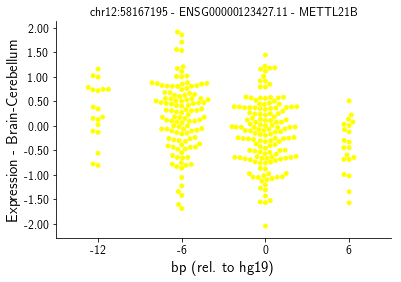

0.940508


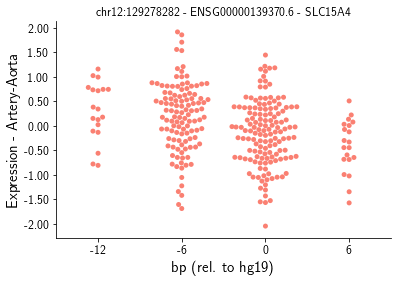

0.953349


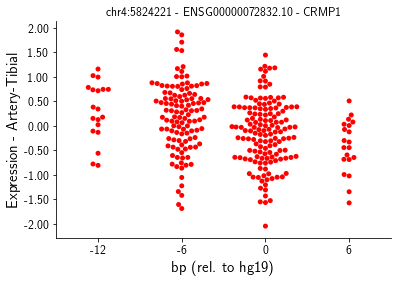

In [19]:
for ind, row in example_gwas.loc[example_gwas['gene.name'].isin(['CRMP1','SLC15A4','METTL21B'])].iterrows():
    gene = row['gene']
    start = str(int(row['str.start']))
    chrom = row['chrom'][3:]
    tissue = row['best.tissue']
    name = row['gene.name']
    print(row['best.score'])
    PlotESTR(gene, tissue, chrom, start, COLORS, name)

#for i in range(len(GENES[:10])):
    #print("%s,%s,%s,%s %s"%(GENES[i], CHROMS[i], STARTS[i], TISSUES[i], QVALS[i]))
    #ExtractData(GENES[i], CHROMS[i].replace("chr",""), STARTS[i], TISSUES[i])
    #PlotESTR(GENES[i], TISSUES[i], CHROMS[i].replace("chr",""), STARTS[i], COLORS)
    #PlotESTR("ENSG00000162244.6", "Adipose-Subcutaneous","3","52027854",COLORS)
    #PlotHeatmap()